In [1]:
import numpy as np
def simulate_stochastic_sirsvd_quarantine_groups(num_of_groups, beta_inside, beta_between,prob_inf_I,prob_inf_asmp,prob_be_asimp,prob_be_simp, quarantine_factor, gamma_1,gamma_2,gamma_3, S0, I0, R0, L, mu, nu, days,I0_asim):

    t = 0
    S = S0
    I0 = I0
    I = I0
    R = R0
    I_a=I0_asim
    susceptible = S
    infected = I0
    recovered = R
    infected_asymptomatic = I_a



    while t < days:
        infected_today = [0]*num_of_groups
        asimptomatic_today = [0]*num_of_groups
        N = []
        p = []
        recovered_infected = []
        recovered_asimptomatic = []
        susceptible_today = []
        for i in range(num_of_groups):


          N.append(susceptible[i][t] + infected[i][t] + recovered[i][t] + infected_asymptomatic[i][t])
          p.append([infected[i][t], quarantine_factor*infected_asymptomatic[i][t],  N[i]-1 - infected[i][t] - infected_asymptomatic[i][t]])
        for i in range(num_of_groups):
          # from S to I (infection)
          if susceptible[i][t] > 0:
              for _ in range(susceptible[i][t]):
                people_average_meetings = [0]*num_of_groups
                people_met_total = []
                for j in range(num_of_groups):
                  if i == j:
                    people_average_meetings[j] = np.random.binomial(N[j]-1, np.min([1,beta_inside[j]/(N[j]-1)]))
                    people_met_total.append(np.random.multinomial(people_average_meetings[j] ,np.array(p[j])/(quarantine_factor*infected[j][t]+susceptible[j][t]+infected_asymptomatic[j][t]+recovered[j][t]-1)))
                  else:
                    people_average_meetings[j] = np.random.binomial(N[j], np.min([1,beta_between/((num_of_groups-1)*(N[j]))]))
                    people_met_total.append(np.random.multinomial(people_average_meetings[j] ,np.array(p[j])/(quarantine_factor*infected[j][t]+susceptible[j][t]+infected_asymptomatic[j][t]+recovered[j][t])))


                # Calculate probability of infection after the contacts
                infect_flag = False
                for people_met in people_met_total:
                  if infect_flag:
                    break
                  Prob_not_inf_I=(1-prob_inf_I)**people_met[0]

                  Prob_not_inf_asmp=(1-prob_inf_asmp)**people_met[1]

                  Prob_total_not_inf=Prob_not_inf_I*Prob_not_inf_asmp

                  Prob_of_inf = 1 - Prob_total_not_inf
                # simulate if got infected
                  u = np.random.uniform()

                  if u <= Prob_of_inf:
                      infect_flag = True
                    # if yes simulate if become simptomatic or asimptomatic
                      u = np.random.uniform()
                      if u <= prob_be_asimp:
                        asimptomatic_today[i] = asimptomatic_today[i] + 1

                      else:
                        infected_today[i] = infected_today[i] + 1
          # from I to R: recovery
          recovered_infected.append(np.random.binomial(infected[i][t], gamma_1))
          recovered_asimptomatic.append(np.random.binomial(infected_asymptomatic[i][t], gamma_3))








          #  from R to S:loss of immunity
          susceptible_today.append(np.random.binomial(recovered[i][t], gamma_2))

        for i in range(num_of_groups):
          # Update compartments and time
          susceptible[i].append(susceptible[i][t] - infected_today[i] - asimptomatic_today[i] + susceptible_today[i])
          infected[i].append(infected[i][t] - recovered_infected[i]  + infected_today[i])
          recovered[i].append(recovered[i][t] + recovered_infected[i] + recovered_asimptomatic[i] - susceptible_today[i])
          infected_asymptomatic[i].append(infected_asymptomatic[i][t] + asimptomatic_today[i] - recovered_asimptomatic[i])
        t += 1

        for i in range(num_of_groups):
          #disease deaths
          deaths = np.random.binomial(infected[i][t], nu)
          infected[i][t] = infected[i][t] - deaths


          #natural deaths

          susceptible[i][t] = susceptible[i][t] - np.random.binomial(susceptible[i][t], mu)
          infected[i][t] = infected[i][t] - np.random.binomial(infected[i][t], mu)
          infected_asymptomatic[i][t] = infected_asymptomatic[i][t] - np.random.binomial(infected_asymptomatic[i][t], mu)
          recovered[i][t] = recovered[i][t] - np.random.binomial(recovered[i][t], mu)

          #births
          births = np.random.binomial(N[i], L)
          susceptible[i][t] = susceptible[i][t] + births





    return susceptible, infected, infected_asymptomatic, recovered

In [2]:
num_of_groups = 5
beta_inside = []
for i in range(num_of_groups):
  beta_inside.append((i+1)*0.4)
beta_between = 0.05
gamma_1 = 0.066
gamma_2 = 0.02
gamma_3 = 0.1
L = 0.00005
mu = 0.000048
nu = 0.001
days = 365*1
quarantine_factor = 0.1
prob_inf_I= 0.2 ; prob_inf_asmp=0.05;
prob_be_asimp = 0.2 ; prob_be_simp=0.8
S0 = []
I0 = []
I0_asim = []
R0 = []
for _ in range(num_of_groups):
  S0.append([2000])
  I0.append([0])
  I0_asim.append([0])
  R0.append([0])


num_of_sims = 1

I0[2] = [10]





susceptible,infected, infected_asymptomatic, recovered=simulate_stochastic_sirsvd_quarantine_groups(num_of_groups, beta_inside, beta_between,prob_inf_I,prob_inf_asmp,prob_be_asimp,prob_be_simp, quarantine_factor, gamma_1,gamma_2,gamma_3, S0, I0, R0, L, mu, nu, days,I0_asim)


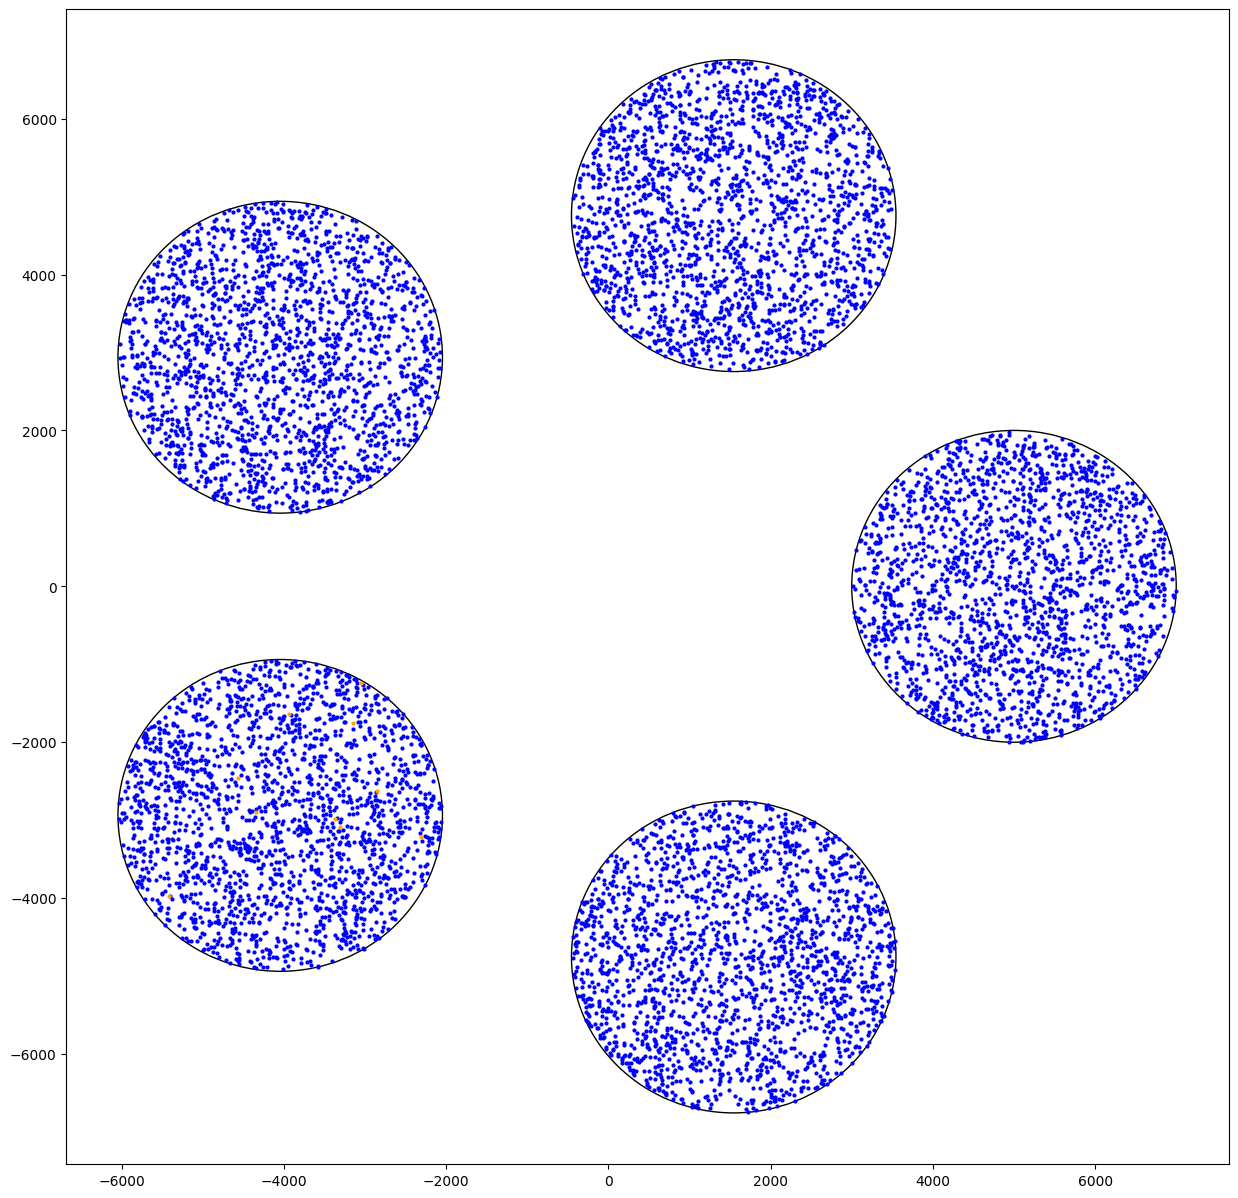

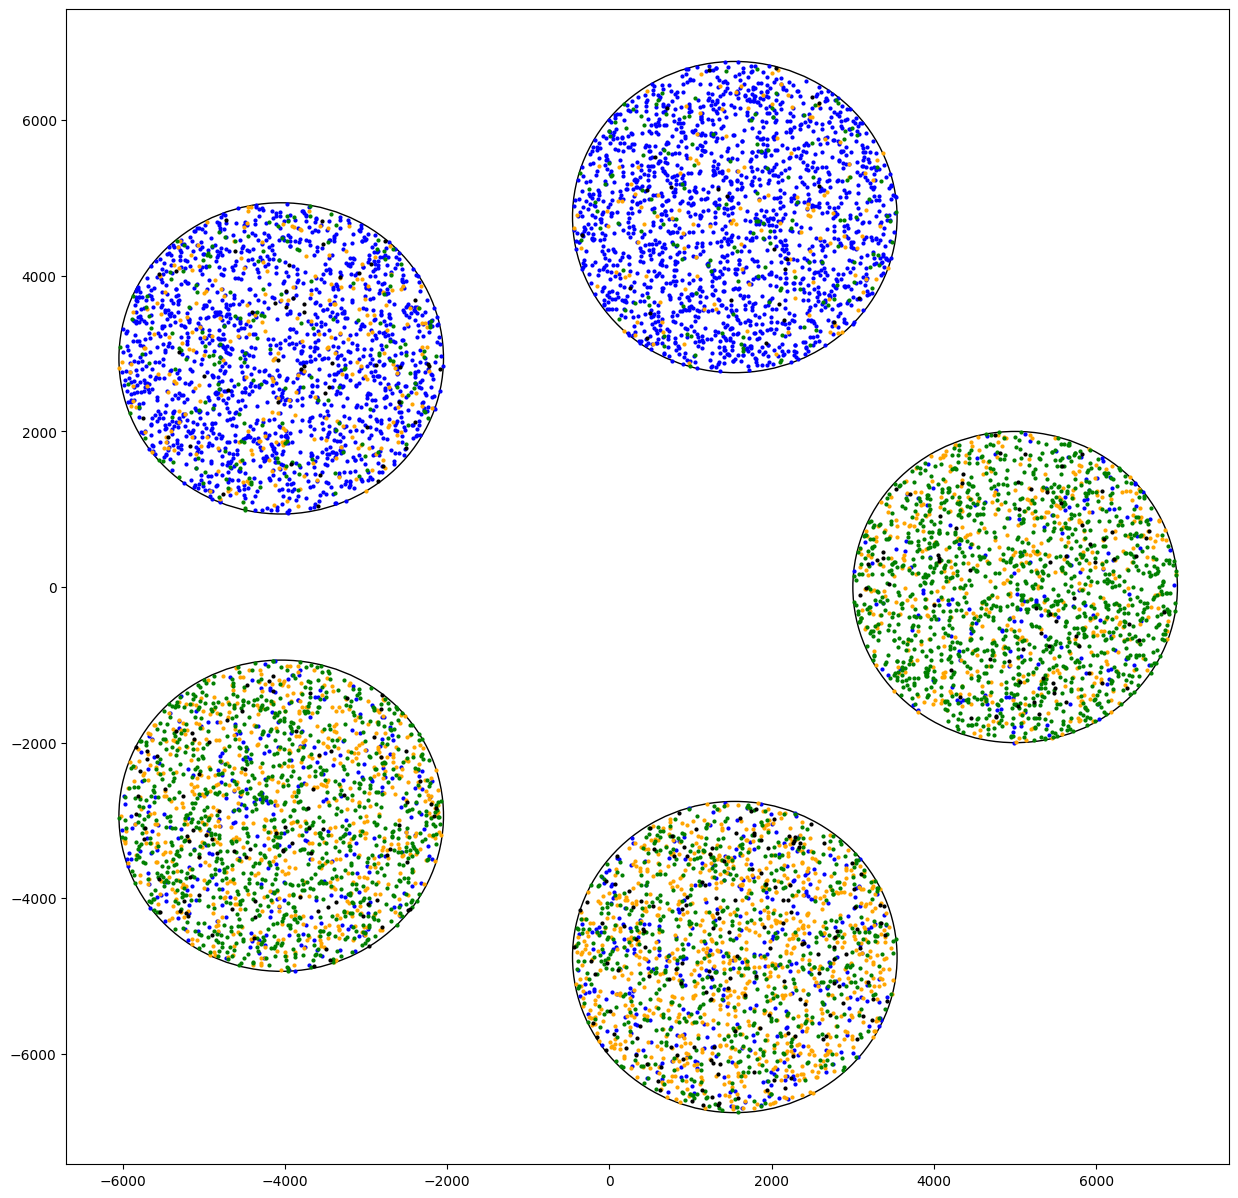

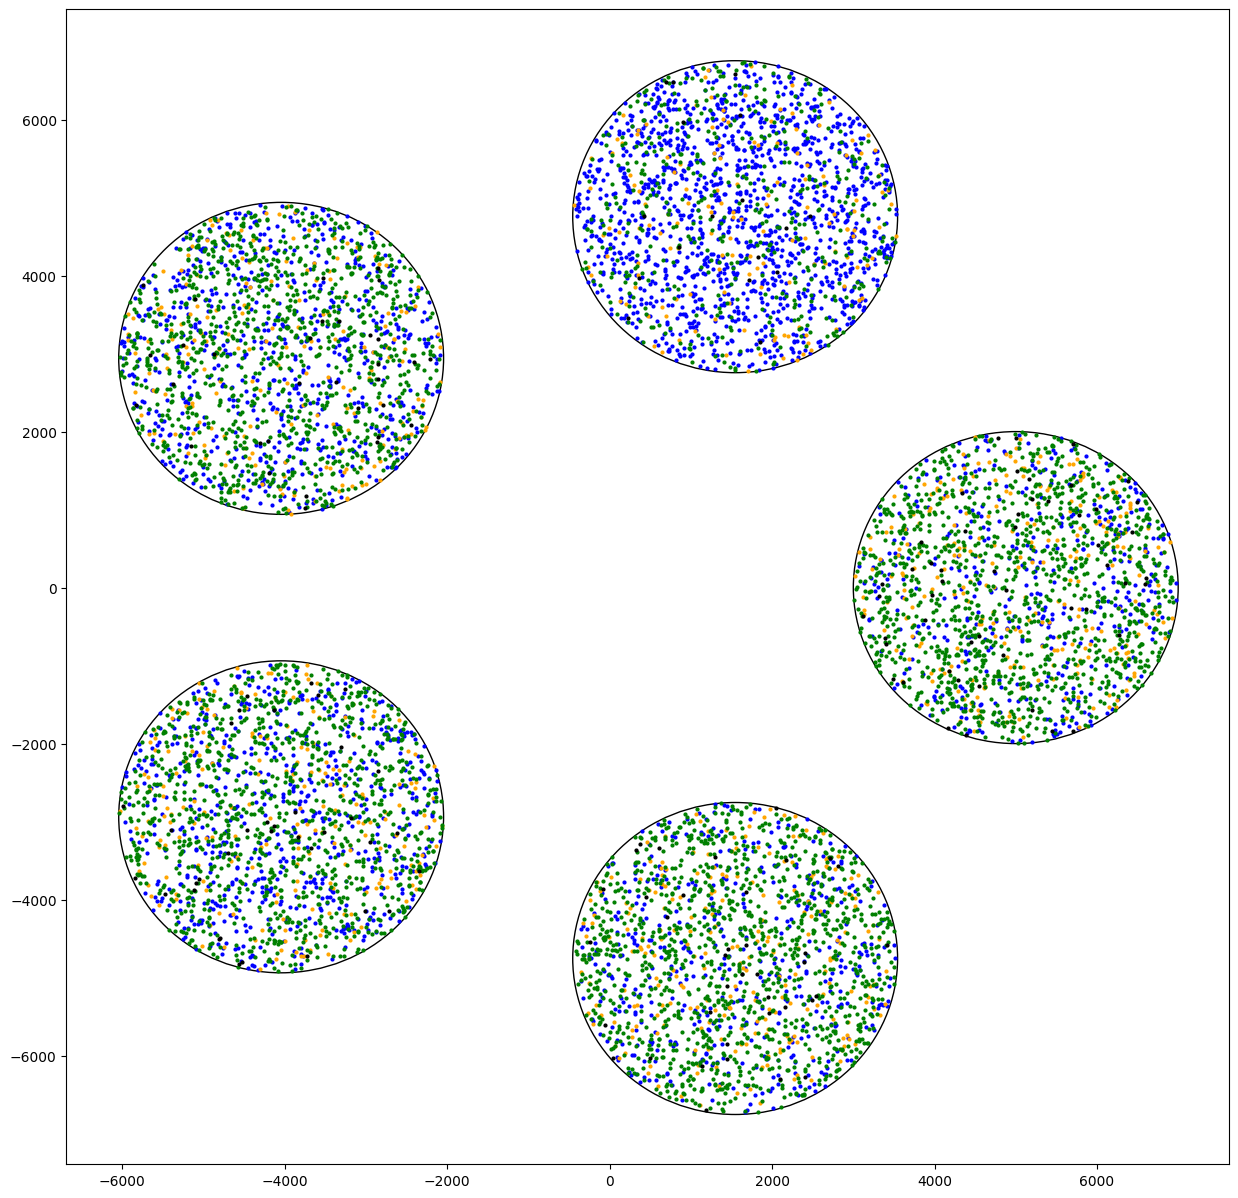

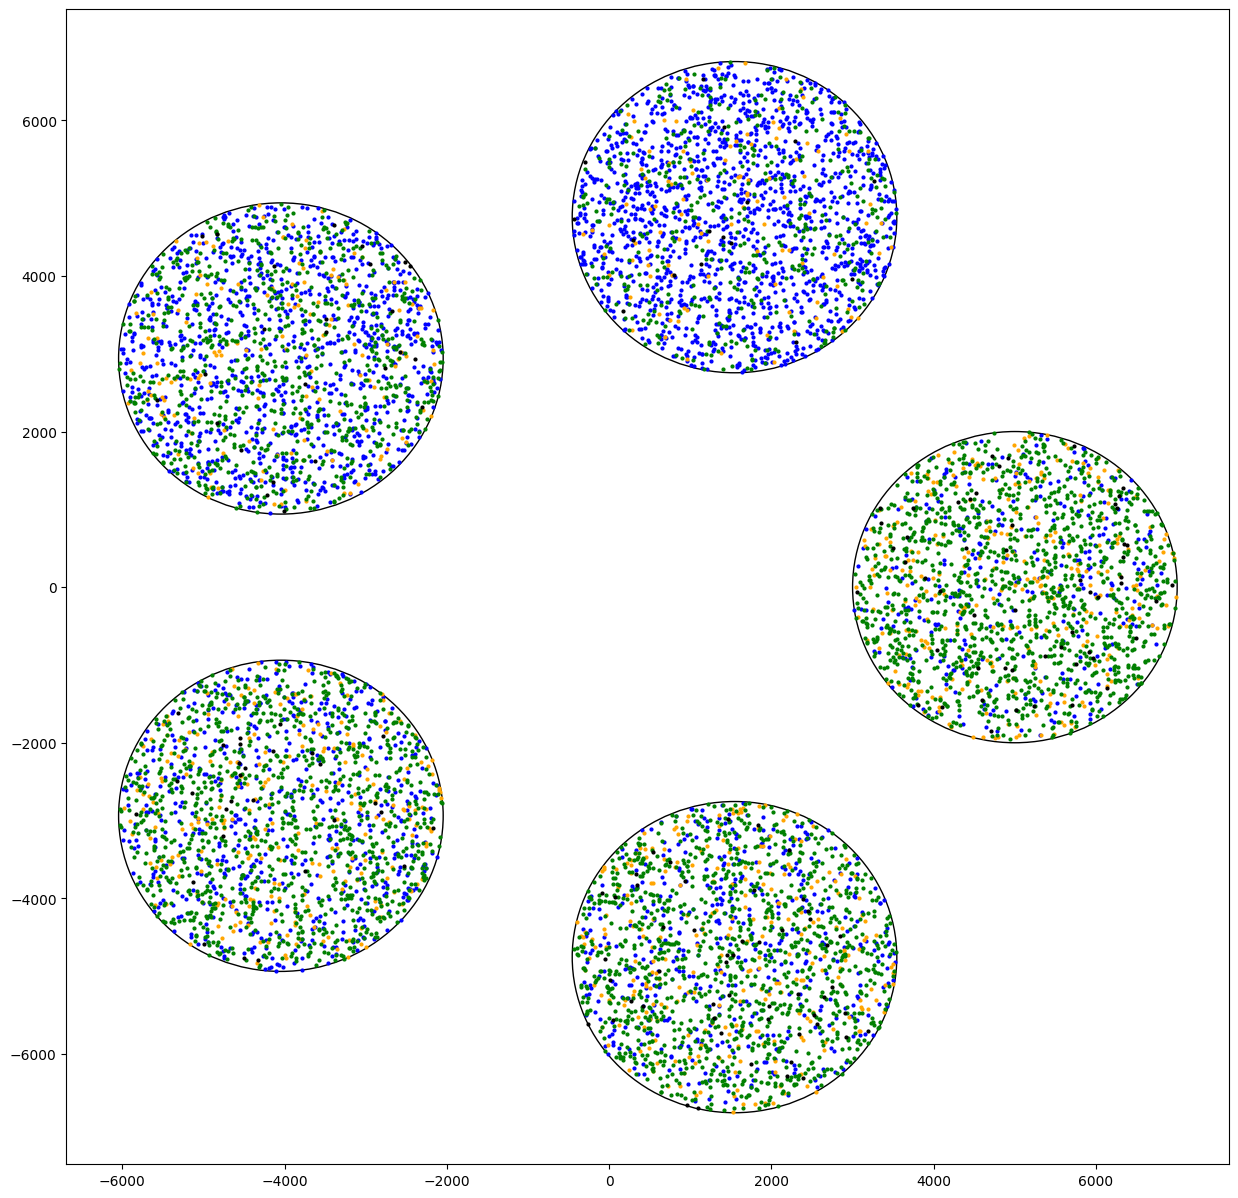

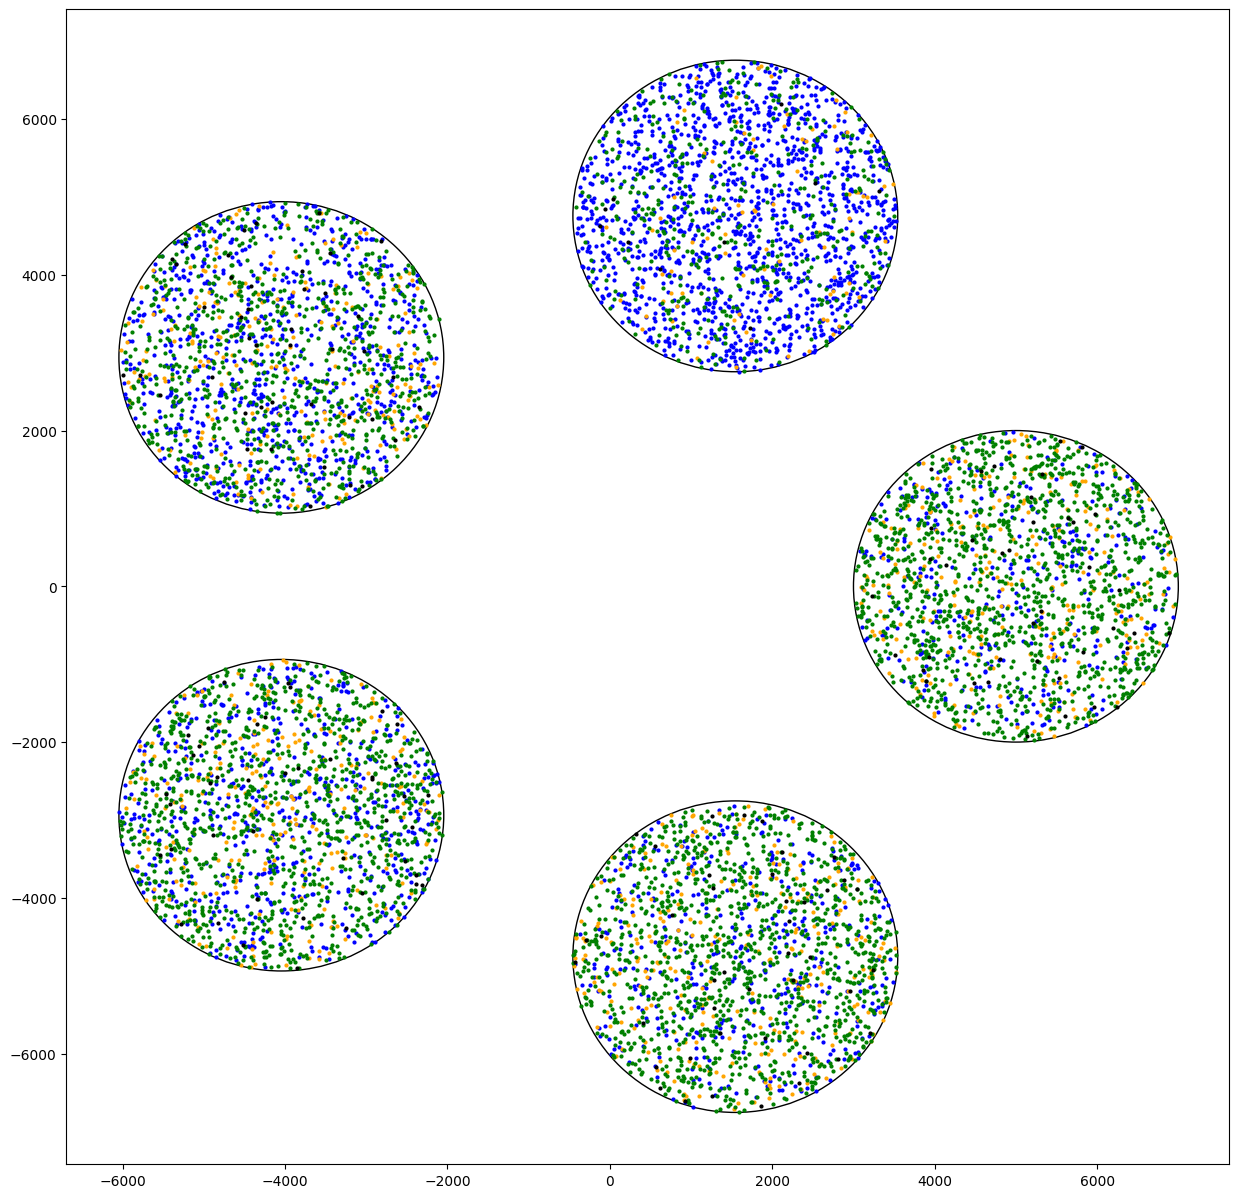

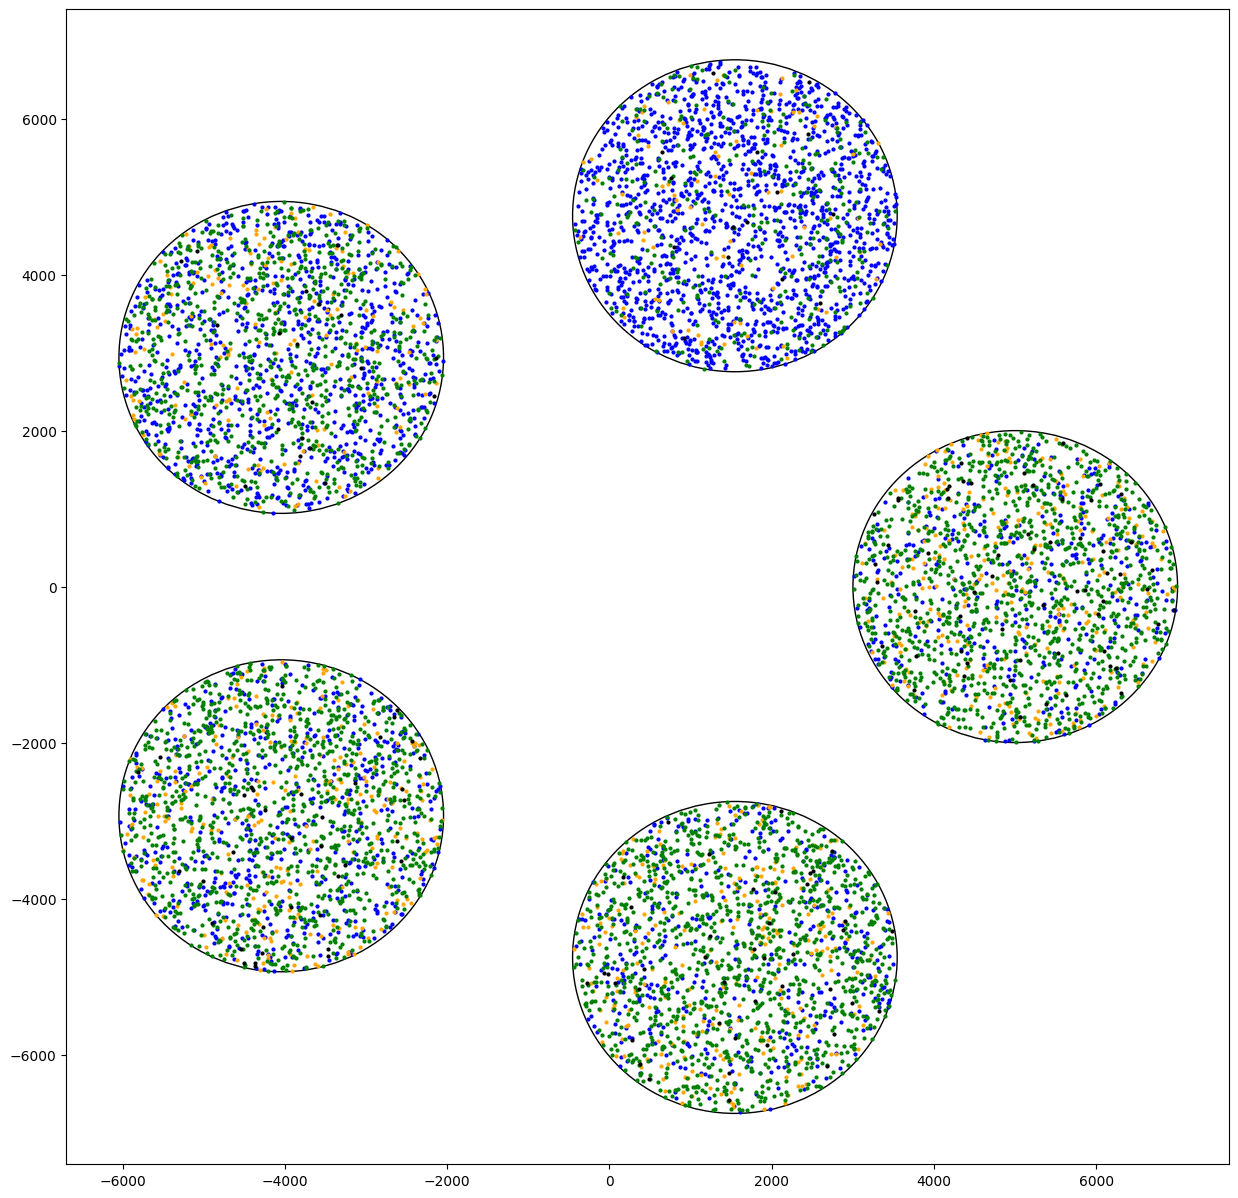

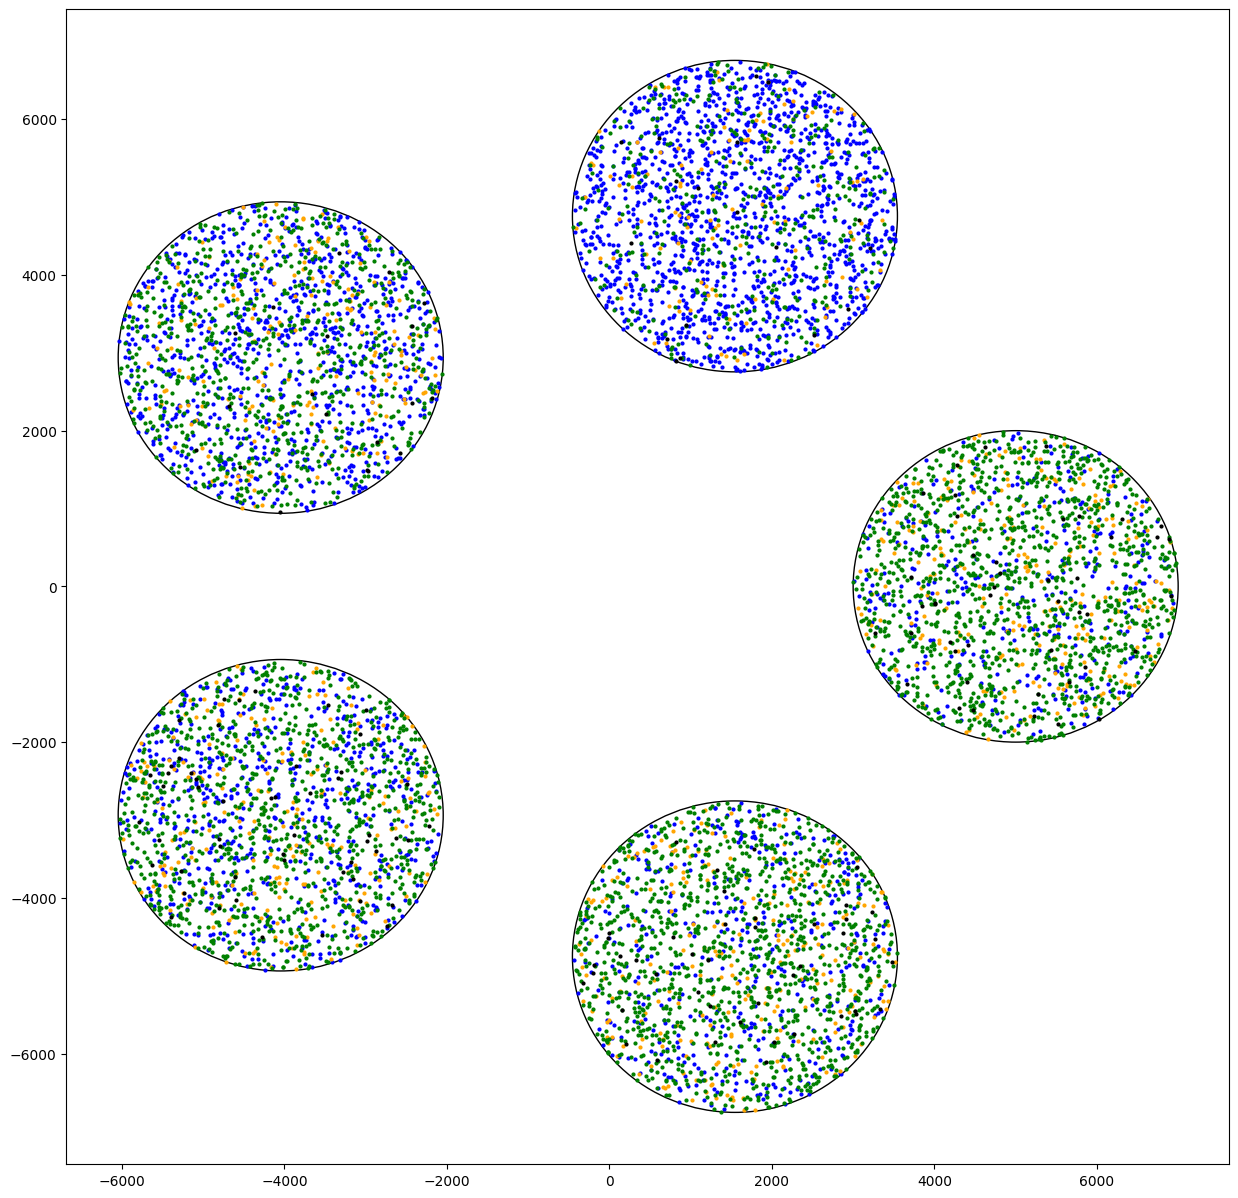

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
import matplotlib
rc('animation', html='jshtml')

circle_centers = []
angles = np.linspace(2*np.pi/num_of_groups,2*np.pi,num_of_groups)
for angle in angles:
  circle_centers.append((num_of_groups*susceptible[0][0]*np.cos(angle)/2,num_of_groups*susceptible[0][0]*np.sin(angle)/2))
#plt.scatter(*zip(*circle_centers))
time_step = 60
for t in range(0, days, time_step):
    coordsx = []
    coordsy = []
    for i in range(num_of_groups):
      for _ in range(susceptible[i][t]//1):
        angle = np.random.uniform(0,2*np.pi)
        radius = np.sqrt(np.random.uniform(0,1))*susceptible[i][0]
        coordsx.append(circle_centers[i][0]+radius*np.cos(angle))
        coordsy.append(circle_centers[i][1]+radius*np.sin(angle))
    
    
    fig, ax = plt.subplots(figsize=(15, 15))
    
    for i in range(num_of_groups):
      Drawing_uncolored_circle = plt.Circle( (circle_centers[i][0], circle_centers[i][1] ),
                                            susceptible[i][0] ,
                                            fill = False )
      ax.add_artist( Drawing_uncolored_circle )
    size_marker = 4
    scat = ax.scatter(coordsx, coordsy, c = 'blue', s=size_marker)
    coordsx = []
    coordsy = []
    for i in range(num_of_groups):
      for _ in range(infected[i][t]//1):
        angle = np.random.uniform(0,2*np.pi)
        radius = np.sqrt(np.random.uniform(0,1))*susceptible[i][0]
        coordsx.append(circle_centers[i][0]+radius*np.cos(angle))
        coordsy.append(circle_centers[i][1]+radius*np.sin(angle))
    scat2 = ax.scatter(coordsx, coordsy, c = 'orange', s=size_marker)
    
    coordsx = []
    coordsy = []
    for i in range(num_of_groups):
      for _ in range(recovered[i][t]//1):
        angle = np.random.uniform(0,2*np.pi)
        radius = np.sqrt(np.random.uniform(0,1))*susceptible[i][0]
        coordsx.append(circle_centers[i][0]+radius*np.cos(angle))
        coordsy.append(circle_centers[i][1]+radius*np.sin(angle))
    scat3 = ax.scatter(coordsx, coordsy, c = 'green', s=size_marker)
    
    coordsx = []
    coordsy = []
    for i in range(num_of_groups):
      for _ in range(infected_asymptomatic[i][t]//1):
        angle = np.random.uniform(0,2*np.pi)
        radius = np.sqrt(np.random.uniform(0,1))*susceptible[i][0]
        coordsx.append(circle_centers[i][0]+radius*np.cos(angle))
        coordsy.append(circle_centers[i][1]+radius*np.sin(angle))
    scat4 = ax.scatter(coordsx, coordsy, c = 'black', s=size_marker)
    
    def update(frame):
        coordsx = []
        coordsy = []
        # for each frame, update the data stored on each artist.
        for i in range(num_of_groups):
    
          for _ in range(susceptible[i][1*frame]//1):
            angle = np.random.uniform(0,2*np.pi)
            radius = np.sqrt(np.random.uniform(0,1))*susceptible[i][0]
            coordsx.append(circle_centers[i][0]+radius*np.cos(angle))
            coordsy.append(circle_centers[i][1]+radius*np.sin(angle))
        data = np.stack([coordsx, coordsy]).T
        scat.set_offsets(data)
        coordsx = []
        coordsy = []
        # for each frame, update the data stored on each artist.
        for i in range(num_of_groups):
    
          for _ in range(infected[i][1*frame]//1):
            angle = np.random.uniform(0,2*np.pi)
            radius = np.sqrt(np.random.uniform(0,1))*susceptible[i][0]
            coordsx.append(circle_centers[i][0]+radius*np.cos(angle))
            coordsy.append(circle_centers[i][1]+radius*np.sin(angle))
        data = np.stack([coordsx, coordsy]).T
        scat2.set_offsets(data)
        coordsx = []
        coordsy = []
        for i in range(num_of_groups):
          for _ in range(recovered[i][1*frame]//1):
            angle = np.random.uniform(0,2*np.pi)
            radius = np.sqrt(np.random.uniform(0,1))*susceptible[i][0]
            coordsx.append(circle_centers[i][0]+radius*np.cos(angle))
            coordsy.append(circle_centers[i][1]+radius*np.sin(angle))
        data = np.stack([coordsx, coordsy]).T
        scat3.set_offsets(data)
    
        coordsx = []
        coordsy = []
        for i in range(num_of_groups):
          for _ in range(infected_asymptomatic[i][1*frame]//1):
            angle = np.random.uniform(0,2*np.pi)
            radius = np.sqrt(np.random.uniform(0,1))*susceptible[i][0]
            coordsx.append(circle_centers[i][0]+radius*np.cos(angle))
            coordsy.append(circle_centers[i][1]+radius*np.sin(angle))
        data = np.stack([coordsx, coordsy]).T
        scat4.set_offsets(data)
        return (scat, scat2,scat3 ,scat4)

#matplotlib.rcParams['animation.embed_limit'] = 2**128
#animation.FuncAnimation(fig=fig, func=update, frames=100, interval=600)